# Passive Image Alignment

This workbook shows a completely passive alignment function using only the RigRelatives present in image metadata.  Older versions of firmware may not include these tags. If your images don't, check the MicaSense [support site](https://support.micasense.com/hc/en-us/articles/360005428953-Updating-RedEdge-for-Pix4Dfields) for some tips on how to update your camera firmware to have them, as well as how to [add them to datasets](https://support.micasense.com/hc/en-us/articles/360006368574-Modifying-older-collections-for-Pix4Dfields-support) prior to the update. 

While this method doesn't provide perfect alignment, it can be fast and very useful for visualization of images when processing power is limited or speed is more important than alignment quality.

## Opening Images

As we have done in previous examples, we use the micasense.capture class to open, radiometrically correct, and visualize the 5 bands of a RedEdge capture.

First, we'll load the `autoreload` extension.  This lets us change underlying code (such as library functions) without having to reload the entire workbook and kernel. This is useful in this workbook because the cell that runs the alignment can take a long time to run, so with `autoreload` extension we can change external code for analysis and visualization without needing to re-compute the alignments each time.

In [1]:
%load_ext autoreload
%autoreload 2

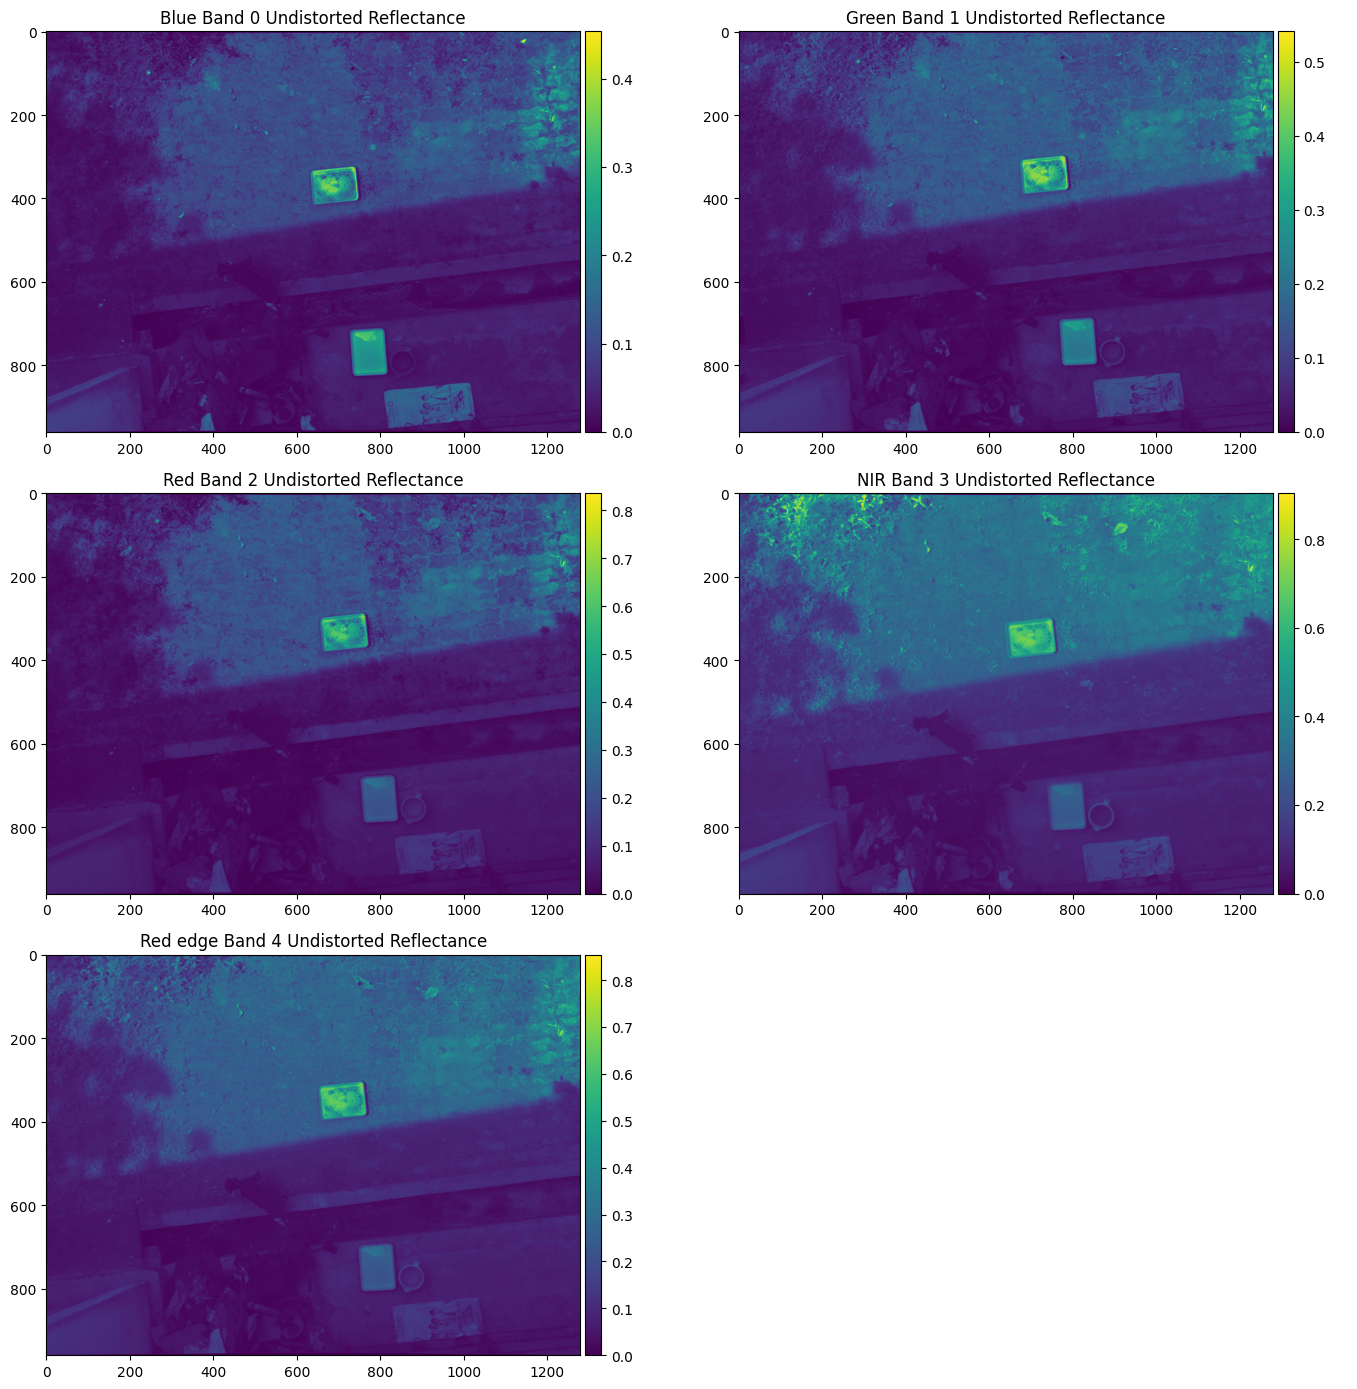

In [11]:
import os, glob
import micasense.capture as capture
%matplotlib inline

panelNames = None

# This is an altum image with RigRelatives and a thermal band
imagePath = os.path.join('.','data','0000SET','000')
imageNames = glob.glob(os.path.join(imagePath,'IMG_0007_*.tif'))
panelNames = glob.glob(os.path.join(imagePath,'IMG_0005_*.tif'))

if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
else:
    panelCap = None

capture = capture.Capture.from_filelist(imageNames)

for img in capture.images:
    if img.rig_relatives is None:
        raise ValueError("Images must have RigRelatives tags set which requires updated firmware and calibration. See the links in text above")

if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
    capture.plot_undistorted_reflectance(panel_irradiance)
else:
    if False: #capture.dls_present():
        img_type='reflectance'
        capture.plot_undistorted_reflectance(capture.dls_irradiance())
    else:
        img_type = "radiance"
        capture.plot_undistorted_radiance()    

## Alignment - Rig Relatives

For images with RigRelative tags present, we can find a rough alignment using only the built in relatives. These can be good for quick visualizatoins.  For better results, use an algorithm like that in the other image alignment tutorial to sweeten the alignment.

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

warp_mode = cv2.MOTION_HOMOGRAPHY
warp_matrices = capture.get_warp_matrices()

cropped_dimensions,edges = imageutils.find_crop_bounds(capture,warp_matrices)
im_aligned = imageutils.aligned_capture(capture, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)

print("warp_matrices={}".format(warp_matrices))

warp_matrices=[array([[ 1.00171752e+00,  2.22757606e-03, -2.87992819e+01],
       [-8.83738139e-04,  1.00006339e+00,  2.74788804e+01],
       [ 3.36533175e-06, -5.73897513e-07,  1.00000000e+00]]), array([[1.00000000e+00, 0.00000000e+00, 1.13686838e-13],
       [0.00000000e+00, 1.00000000e+00, 5.68434189e-14],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), array([[ 9.97949296e-01,  9.35044329e-03, -2.00945736e+01],
       [-8.77081517e-03,  9.99449827e-01,  5.69465708e+00],
       [-1.16864717e-06,  1.79157052e-06,  1.00000000e+00]]), array([[ 1.00780825e+00,  9.75608290e-03, -2.84813004e+01],
       [-9.91453833e-03,  1.00762615e+00,  1.76317236e+01],
       [ 4.99915758e-07, -6.31952108e-07,  1.00000000e+00]]), array([[ 1.00068180e+00,  6.28768089e-03, -1.72304036e+01],
       [-5.10085052e-03,  1.00043105e+00,  1.58301307e+01],
       [ 1.37402551e-06,  7.89207442e-07,  1.00000000e+00]])]


## Visualize Aligned Images

Once the transformation has been found, it can be verified by composting the aligned images to check alignment. The image 'stack' containing all bands can also be exported to a multi-band TIFF file for viewing in extrernal software such as QGIS.  Usef ul componsites are a naturally colored RGB as well as color infrared, or CIR.

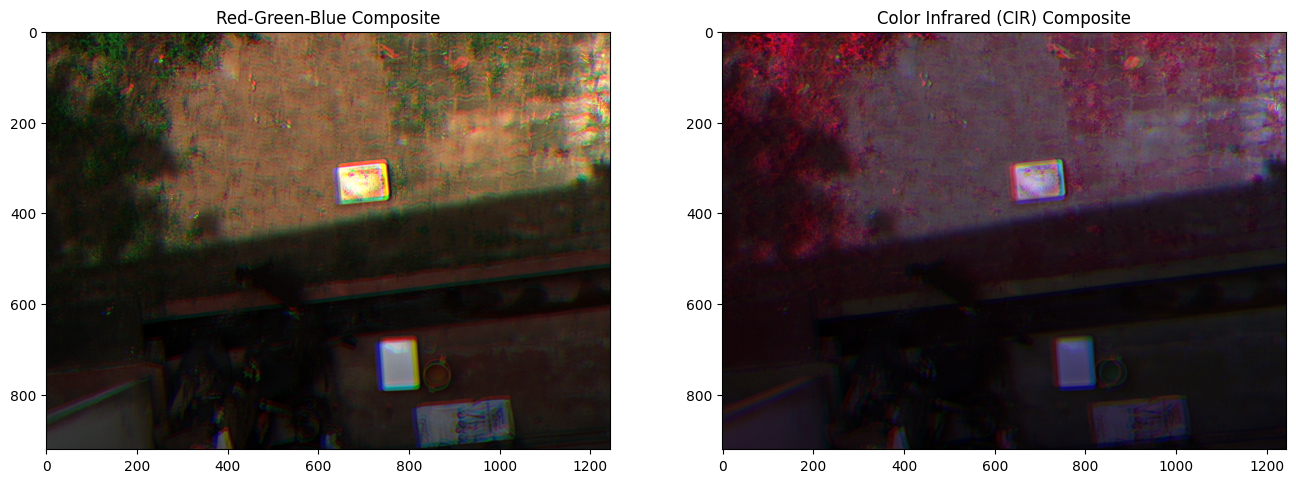

In [13]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [2,1,0]
cir_band_indices = [3,2,1]

# Create an empty normalized stack for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],capture.num_bands+1), dtype=np.float32 )

im_min = np.percentile(im_aligned[:,:,0:2].flatten(),  0.1)  # modify with these percentilse to adjust contrast
im_max = np.percentile(im_aligned[:,:,0:2].flatten(), 99.9)  # for many images, 0.5 and 99.5 are good values

for i in range(0,im_aligned.shape[2]):
    if img_type == 'reflectance':
        # for reflectance images we maintain white-balance by applying the same display scaling to all bands
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
    elif img_type == 'radiance':
        # for radiance images we do an auto white balance since we don't know the input light spectrum by
        # stretching each display band histogram to it's own min and max
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

rgb = im_display[:,:,rgb_band_indices]
# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
fig, axes = plt.subplots(1, 2, figsize=figsize)
axes[0].set_title("Red-Green-Blue Composite")
axes[0].imshow(rgb)
axes[1].set_title("Color Infrared (CIR) Composite")
axes[1].imshow(cir)
plt.show()

## Image Enhancement

There are many techniques for image enhancement, but one which is commonly used to improve the visual sharpness of imagery is the unsharp mask.  Here we apply an unsharp mask to the RGB image to improve the visualization, and then apply a gamma curve to make the darkest areas brighter.

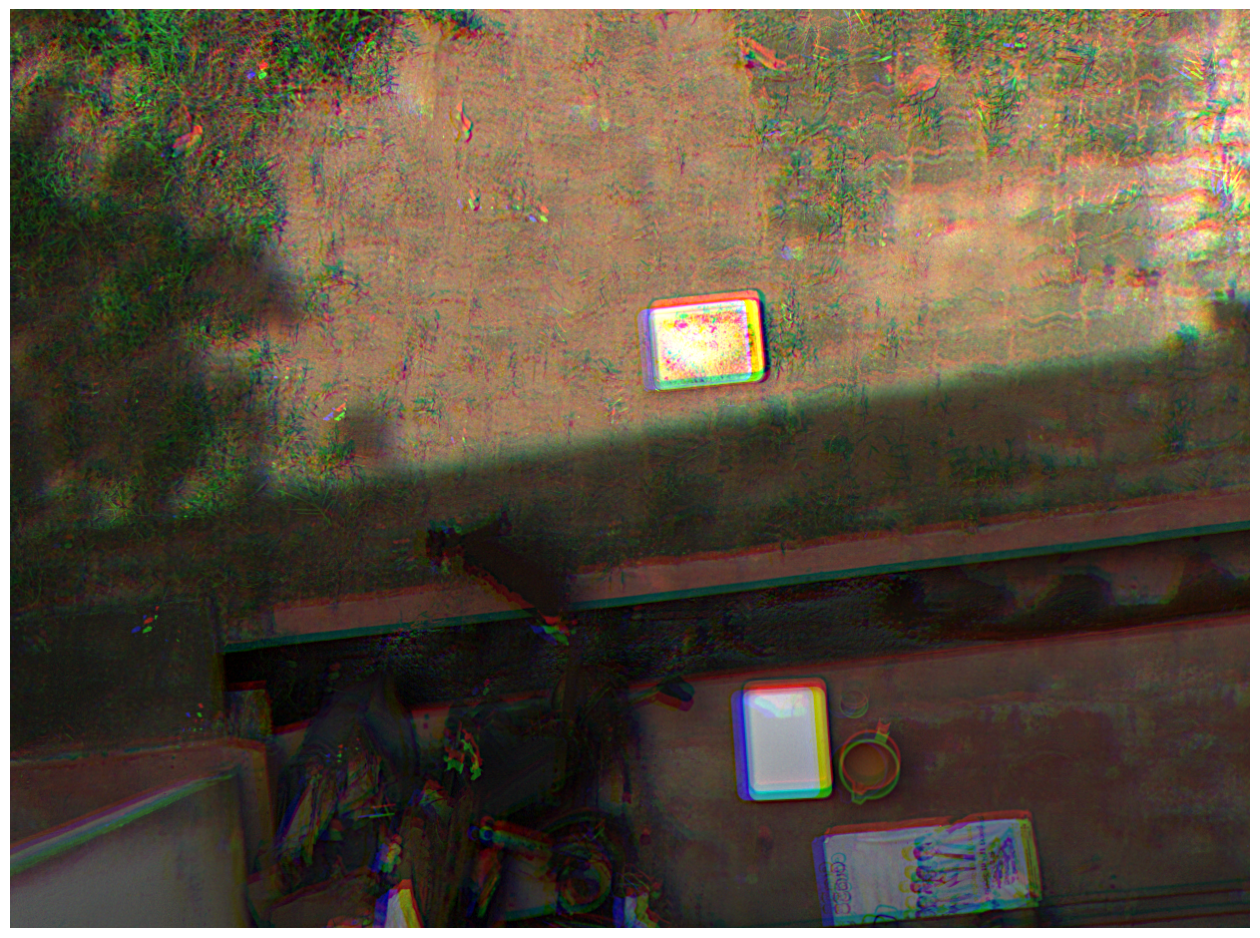

In [14]:
# Create an enhanced version of the RGB render using an unsharp mask
gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
gaussian_rgb[gaussian_rgb<0] = 0
gaussian_rgb[gaussian_rgb>1] = 1
unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
unsharp_rgb[unsharp_rgb<0] = 0
unsharp_rgb[unsharp_rgb>1] = 1

# Apply a gamma correction to make the render appear closer to what our eyes would see
gamma = 1.4
gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
fig = plt.figure(figsize=figsize)
plt.imshow(gamma_corr_rgb, aspect='equal')
plt.axis('off')
plt.show()

## Rendered Image output

We can output the image to a PNG or JPEG file for viewing. This can also be useful in creating thumbnails of captures.

In [15]:
import imageio
imtype = 'png' # or 'jpg'
imageio.imwrite('rgb.'+imtype, (255*gamma_corr_rgb).astype('uint8'))

## Stack Export

We can export the image easily stacks using the `gdal` library (http://www.glal.org). Once exported, these image stacks can be opened in software such as QGIS and raster operations such as NDVI or NDRE computation can be done in that software.  At this time the stacks don't include any geographic information.

In [16]:
from osgeo import gdal, gdal_array
rows, cols, bands = im_display.shape
driver = gdal.GetDriverByName('GTiff')
filename = "bgrne" #blue,green,red,nir,redEdge

if im_aligned.shape[2] == 6:
    filename = filename + "t" #thermal
outRaster = driver.Create(filename+".tiff", cols, rows, im_aligned.shape[2], gdal.GDT_UInt16)

normalize = (img_type == 'radiance') # normalize radiance images to fit with in UInt16

# Output a 'stack' in the same band order as RedEdge/Alutm
# Blue,Green,Red,NIR,RedEdge[,Thermal]
# reflectance stacks are output with 32768=100% reflectance to provide some overhead for specular reflections
# radiance stacks are output with 65535=100% radiance to provide some overhead for specular reflections

# NOTE: NIR and RedEdge are not in wavelength order!

multispec_min = np.min(im_aligned[:,:,1:5])
multispec_max = np.max(im_aligned[:,:,1:5])

for i in range(0,5):
    outband = outRaster.GetRasterBand(i+1)
    if normalize:
        outdata = imageutils.normalize(im_aligned[:,:,i],multispec_min,multispec_max)
    else:
        outdata = im_aligned[:,:,i]
        outdata[outdata<0] = 0
        outdata[outdata>2] = 2
    
    outdata = outdata*32767
    outdata[outdata<0] = 0
    outdata[outdata>65535] = 65535
    outband.WriteArray(outdata)
    outband.FlushCache()

if im_aligned.shape[2] == 6:
    outband = outRaster.GetRasterBand(6)
    outdata = im_aligned[:,:,5] * 100 # scale to centi-C to fit into uint16
    outdata[outdata<0] = 0
    outdata[outdata>65535] = 65535
    outband.WriteArray(outdata)
    outband.FlushCache()
outRaster = None

ModuleNotFoundError: No module named 'osgeo'

### Notes on Alignment and Stack Usage

"Stacks" as described above are useful in a number of processing cases.  For example, at the time of this writing, many photogrammetry suites could import and process stack files without significantly impacting the radiometric processing which has already been accomplished.  

Running photogrammetry on stack files instead of raw image files has both advantages and drawbacks. The primary advantage has been found to be an increase in processing speed and a reduction in program memory usage. As the photogrammetric workflow generally operates on luminance images and may not use color information, stacked images may require similar resources and be processed at a similar speed as single-band images.  This is because one band of the stack can be used to generate the matching feature space while the others are ignored for matching purposes. This reduces the feature space 5-fold over matching using all images separately.

One disadvantage is that stacking images outside of the photogrammetric workflow may result in poor image matching.  The RedEdge is known to have stable lens characteristics over the course of normal operation, but variations in temperature or impacts to the camera through handling or rough landings may change the image alignment parameters.  For this reason, we recommend finding a matching transformation for each flight (each take-off and landing).  Alignment transformations from multiple images within a flight can be compared to find the best transformation to apply to the set of the flight.  While not described or supported in this generic implementation, some matching algorithms can use a "seed" value as a starting point to speed up matching.  For most cases, this seed could be the transformation found in a previous flight, or another source of a known good transformation.    

## NDVI Computation

For raw index computation on single images, the numpy package provides a simple way to do math and simple visualizatoin on images.  Below, we compute and visualize an image histogram and then use that to pick a colormap range for visualizing the NDVI of an image. 

### Plant Classification

After computing the NDVI and prior to displaying it, we use a very rudimentary method for focusing on the plants and removing the soil and shadow information from our images and histograms. Below we remove non-plant pixels by setting to zero any pixels in the image where the NIR reflectance is less than 20%.  This helps to ensure that the NDVI and NDRE histograms aren't skewed substantially by soil noise.

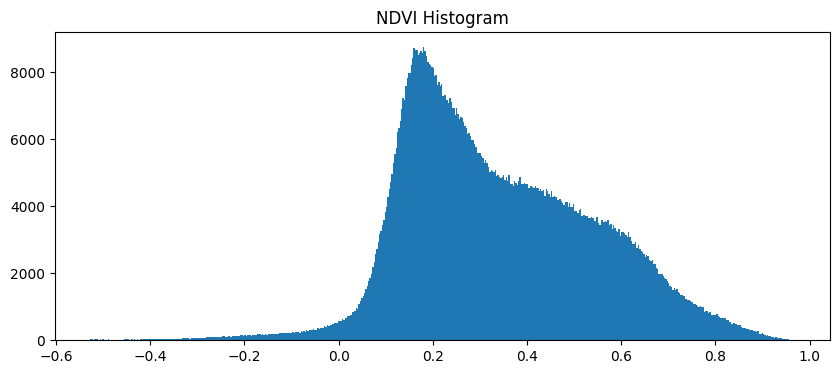

/opt/homebrew/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


ValueError: output array is read-only

In [17]:
from micasense import plotutils
import matplotlib.pyplot as plt

np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero errors in the index calculation

# Compute Normalized Difference Vegetation Index (NDVI) from the NIR(3) and RED (2) bands
ndvi = (im_aligned[:,:,3] - im_aligned[:,:,2]) / (im_aligned[:,:,3] + im_aligned[:,:,2])

# remove shadowed areas (mask pixels with NIR reflectance < 20%))
if img_type == 'reflectance':
    ndvi = np.ma.masked_where(im_aligned[:,:,3] < 0.20, ndvi) 
elif img_type == 'radiance':
    lower_pct_radiance = np.percentile(im_aligned[:,:,3],  10.0)
    ndvi = np.ma.masked_where(im_aligned[:,:,3] < lower_pct_radiance, ndvi) 
    
# Compute and display a histogram
ndvi_hist_min = np.min(ndvi)
ndvi_hist_max = np.max(ndvi)
fig, axis = plt.subplots(1, 1, figsize=(10,4))
axis.hist(ndvi.ravel(), bins=512, range=(ndvi_hist_min, ndvi_hist_max))
plt.title("NDVI Histogram")
plt.show()

min_display_ndvi = 0.45 # further mask soil by removing low-ndvi values
#min_display_ndvi = np.percentile(ndvi.flatten(),  5.0)  # modify with these percentilse to adjust contrast
max_display_ndvi = np.percentile(ndvi.flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values
masked_ndvi = np.ma.masked_where(ndvi < min_display_ndvi, ndvi)

#reduce the figure size to account for colorbar
figsize=np.asarray(figsize) - np.array([3,2])

#plot NDVI over an RGB basemap, with a colorbar showing the NDVI scale
fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb, 
                                    masked_ndvi, 
                                    figsize = figsize, 
                                    title = 'NDVI filtered to only plants over RGB base layer',
                                    vmin = min_display_ndvi,
                                    vmax = max_display_ndvi)
fig.savefig('ndvi_over_rgb.png')

## NDRE Computation

In the same manner, we can compute, filter, and display another index useful for the RedEdge camera, the Normalized Difference Red Edge (NDRE) index.  We also filter out shadows and soil to ensure our display focuses only on the plant health.

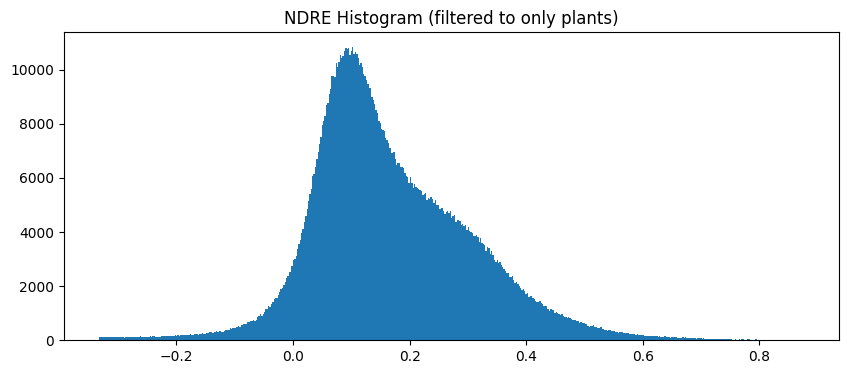

ValueError: output array is read-only

In [18]:
# Compute Normalized Difference Red Edge Index from the NIR(3) and RedEdge(4) bands
ndre = (im_aligned[:,:,3] - im_aligned[:,:,4]) / (im_aligned[:,:,3] + im_aligned[:,:,4])

# Mask areas with shadows and low NDVI to remove soil
masked_ndre = np.ma.masked_where(ndvi < min_display_ndvi, ndre)

# Compute a histogram
ndre_hist_min = np.min(masked_ndre)
ndre_hist_max = np.max(masked_ndre)
fig, axis = plt.subplots(1, 1, figsize=(10,4))
axis.hist(masked_ndre.ravel(), bins=512, range=(ndre_hist_min, ndre_hist_max))
plt.title("NDRE Histogram (filtered to only plants)")
plt.show()

min_display_ndre = np.percentile(masked_ndre, 5)
max_display_ndre = np.percentile(masked_ndre, 99.5)

fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb, 
                                    masked_ndre, 
                                    figsize=figsize, 
                                    title='NDRE filtered to only plants over RGB base layer',
                                    vmin=min_display_ndre,vmax=max_display_ndre)
fig.savefig('ndre_over_rgb.png')

## Thermal Imagery

If our image is from an Altum and includes a thermal band, we can display the re-sampled and aligned thermal data over the RGB data to maintain the context of the thermal information.

In the image below, it's very clear based on the average temperature where the soil is wet and dry, and even in the middle of the road we can find some wetter areas of soil.

In [20]:
if im_aligned.shape[2] >= 5:

    # by default we don't mask the thermal, since it's native resolution is much lower than the MS
    masked_thermal = im_aligned[:,:,5]
    # Alternatively we can mask the thermal only to plants here, which is useful for large contiguous areas
    # masked_thermal = np.ma.masked_where(ndvi < 0.45, im_aligned[:,:,5])


    # Compute a histogram
    fig, axis = plt.subplots(1, 1, figsize=(10,4))
    axis.hist(masked_thermal.ravel(), bins=512, range=(np.min(masked_thermal), np.max(masked_thermal)))
    plt.title("Thermal Histogram")
    plt.show()

    min_display_therm = np.percentile(masked_thermal, 1)
    max_display_therm = np.percentile(masked_thermal, 99)

    fig, axis = plotutils.plot_overlay_withcolorbar(gamma_corr_rgb,
                                        masked_thermal, 
                                        figsize=figsize, 
                                        title='Temperature over True Color',
                                        vmin=min_display_therm,vmax=max_display_therm,
                                        overlay_alpha=0.25,
                                        overlay_colormap='jet',
                                        overlay_steps=16,
                                        display_contours=True,
                                        contour_steps=16,
                                        contour_alpha=.4,
                                        contour_fmt="%.0fC")
    fig.savefig('thermal_over_rgb.png')

IndexError: index 5 is out of bounds for axis 2 with size 5

---
Copyright (c) 2017-2019 MicaSense, Inc.  For licensing information see the [project git repository](https://github.com/micasense/imageprocessing)